In [1]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
import random

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

# SEED = 23                       
# np.random.seed(SEED)
# random.seed(SEED)
# pnp.random.seed(SEED) 

import warnings
warnings.filterwarnings('ignore')

In [2]:
##############################################################################
# 1) define devices:  noiseless ("default.qubit"),  noisy ("default.mixed").
##############################################################################

# noiseless device
dev_exact = qml.device("default.qubit", wires = 2, shots = None)

# niosy device (simple amplitude + phase damping model)
# "shots=1024" is used so we can mimic a finite-sample experiment.
dev_noisy = qml.device(
    "default.mixed",
    wires = 2,
    shots = 1024)

# try:
#     dev_noisy.rng = np.random.default_rng(SEED)
# except AttributeError:
#     pass 

In [3]:
##############################################################################
# 2) define the H2 Hamiltonian, the ansatz, and nuclear repulsion shift.
##############################################################################

# H2 Hamiltonian coefficients
coeffs = {
    'c0': -1.0523732,
    'c1':  0.39793742,
    'c2': -0.3979374,
    'c3': -0.0112801,
    'c4':  0.18093119
}
# nuclear repulsion shift for H2 at R=0.75 A
nuclear_repulsion = 0.7199689944489797

# place coefficients in list for easier access
coefs_list = [
    coeffs['c0'],
    coeffs['c1'],
    coeffs['c2'],
    coeffs['c3'],
    coeffs['c4']
]
ops_list = [
    qml.Identity(0) @ qml.Identity(1),
    qml.Identity(0) @ qml.PauliZ(1),
    qml.PauliZ(0)   @ qml.Identity(1),
    qml.PauliZ(0)   @ qml.PauliZ(1),
    qml.PauliX(0)   @ qml.PauliX(1)
]
H = qml.Hamiltonian(coefs_list, ops_list)

In [4]:
# ansatz with two parameters repeated to some "circuit_depth".
def ansatz(params, circuit_depth=2, gamma=0.1, phi=0.1, noisy=False):
    """
        Applies RY-RZ layers plus CNOTs, optionally inserting amplitude & phase damping on both wires if noisy method is selected.
        'gamma' and 'phi' set the damping rates for amplitude and phase damping, respectively.
    """
    theta1, theta2 = params

    # initial single-qubit gates
    for w in range(2):
        qml.RY(theta1, wires=w)
        qml.RZ(theta1, wires=w)

    if noisy:
        # amplitude & phase damping with user-defined gamma, phi
        qml.AmplitudeDamping(gamma, wires=0)
        qml.PhaseDamping(phi, wires=1)

    # repeated pattern: chain of CNOTs + single-qubit rotations
    for _ in range(circuit_depth):
        qml.CNOT(wires=[0, 1])
        for w in range(2):
            qml.RY(theta2, wires = w)
            qml.RZ(theta2, wires = w)

In [5]:
# We define a QNode that takes 'scale_factor' to scale the amplitude/phase damping
# For example, gamma = 0.1*scale_factor, phi = 0.1*scale_factor
@qml.qnode(dev_noisy)
def circuit_noisy_scaled(params, circuit_depth = 2, scale_factor = 1.0):
    gamma = 0.1 * scale_factor
    phi   = 0.1 * scale_factor
    ansatz(params, circuit_depth=circuit_depth, gamma=gamma, phi = phi, noisy = True)
    return qml.expval(H)

In [6]:
##############################################################################
# 3) define QNodes and cost functions for exact, noisy, and CDR runs.
##############################################################################

@qml.qnode(dev_exact)
def circuit_exact(params, circuit_depth = 2):
    ansatz(params, circuit_depth = circuit_depth, noisy = False)
    return qml.expval(H)

@qml.qnode(dev_noisy)
def circuit_noisy(params, circuit_depth=2):
    ansatz(params, circuit_depth = circuit_depth, noisy = True)
    return qml.expval(H)

def cost_exact(params, circuit_depth = 2):
    return circuit_exact(params, circuit_depth=circuit_depth) + nuclear_repulsion

def cost_noisy(params, circuit_depth=2, scale_factor = 1.0):
    return circuit_noisy_scaled(params, circuit_depth=circuit_depth, scale_factor=scale_factor) + nuclear_repulsion

In [7]:
##############################################################################
# 4) random near-Clifford circuit generation for training.
##############################################################################

def random_clifford_params(params, snap_prob = 0.3):
    """
        with probability 'snap_prob' per angle, snap it to the nearest multiple of pi/2,
        making it effectively a Clifford rotation. otherwise keep original angle.
    """
    out = []
    for angle in params:
        if np.random.rand() < snap_prob:
            # snap to multiple of pi/2
            # we'll pick whichever multiple of pi/2 is nearest, or pick randomly:
            # multiples of pi/2 in [0, 2π) are: 0, π/2, π, 3π/2
            # you can also choose from -∞,∞ but mod 2π. we do mod 2π:
            angle_mod_2pi = angle % (2*np.pi)
            multiples = np.array([0., np.pi/2, np.pi, 3*np.pi/2])
            # find whichever of these is nearest
            diffs = np.abs(multiples - angle_mod_2pi)
            idx = np.argmin(diffs)
            # we then re-insert the integer multiple, but keep same quadrant shift from original
            snapped_val = multiples[idx]  # This is in [0, 2π)
            # we can either just take snapped_val or do angle - angle_mod_2pi + snapped_val
            # so we preserve the same "2π offset" as the original. usually it doesn't matter
            # because angles are periodic
            base = angle - angle_mod_2pi
            out.append(base + snapped_val)
        else:
            # keep original
            out.append(angle)
    return np.array(out)

In [8]:
SCALE_FACTORS  = [1.0, 1.3, 1.5]
POOL_SIZE      = 1000
CIRCUIT_DEPTH  = 2

# select random seed so same circuits are picked for all models
# this is to make sure that it is not randomly picked at each iteration of the optimization
np.random.seed(23)                       
train_pool = [random_clifford_params(
                  np.random.uniform(0, 2*np.pi, size = 2),   
                  snap_prob = 0.3)
              for _ in range(POOL_SIZE)]

def generate_cdr_training_data(params, n_train = 50, circuit_depth = 2):
    """
        Draw 'n_train' circuits without replacement from the global pool
        (wrap-around if needed).  Guarantees that every optimisation call
        sees reproducible training samples.
    """
    global pool_idx
    idx = np.arange(pool_idx, pool_idx + n_train) % POOL_SIZE
    # advance the cursor
    pool_idx = (pool_idx + n_train) % POOL_SIZE        

    # initialize the list for storing the data
    X_noisy, Y_exact = [], []
    # loop over each selected circuit parameter from the training pool
    for cparams in (train_pool[i] for i in idx):
        # evaluate the "ideal" expectation value (i.e., noise free result)
        E_exact = cost_exact(cparams, circuit_depth = circuit_depth)
        # evaluate noisy expectation values at different noise scales
        # these form the features for training the regression model
        noisy_vec = [cost_noisy(cparams, circuit_depth = circuit_depth,
                                scale_factor=sf)
                     for sf in SCALE_FACTORS]
        X_noisy.append(noisy_vec)
        Y_exact.append(E_exact)
    # convert the training inputs and targets into NumPy arrays for model training
    return np.asarray(X_noisy, float), np.asarray(Y_exact, float)

pool_idx = 0 

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# additional sklearn regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)

# unified cdr regression helper
def cdr_model(
    x_noisy,
    y_exact,
    x_test,
    *,
    model = "linear",
    alpha = 0.1,
    # ---- random forest ----
    rf_n_estimators = 300,
    rf_max_depth = None,
    # ---- gradient boosting ----
    gbr_n_estimators = 500,
    gbr_lr = 0.05,
    gbr_max_depth = 3,
    # ---- adaboost ----
    ada_n_estimators = 400,
    ada_lr = 0.1,
    ada_max_depth = 4,
):
    # fits a regression model on (x_noisy, y_exact) and predicts for x_test
    # supported models: linear, ridge, lasso, rf, gbr, adaboost, etc.
    # all keyword hyperparameters have defaults but can be overridden

    # 1) standardize features (even tree models will be fed standardized data)
    scaler = StandardScaler()
    xs = scaler.fit_transform(x_noisy)
    x_test_ = scaler.transform([x_test])

    # 2) choose and configure the regressor
    if model == "linear":
        reg = LinearRegression()

    elif model == "ridge":
        reg = Ridge(alpha = alpha, max_iter = 10000, tol = 0.0001)

    elif model == "lasso":
        lasso = Lasso(max_iter = 10000, tol = 0.0001)
        grid = GridSearchCV(
            lasso,
            param_grid = {"alpha": [0.001, 0.01, 0.1, 1.0]},
            cv = 5
        )
        grid.fit(xs, y_exact)
        reg = grid.best_estimator_

    elif model in ("rf", "random_forest"):
        reg = RandomForestRegressor(
            n_estimators = rf_n_estimators,
            max_depth = rf_max_depth,
            random_state = random_state,
            n_jobs = 1
        )
    elif model in ("gbr", "gradboost"):
        reg = GradientBoostingRegressor(
            n_estimators = gbr_n_estimators,
            learning_rate = gbr_lr,
            max_depth = gbr_max_depth,
            random_state = random_state
        )
    elif model == "adaboost":
        base = DecisionTreeRegressor(
            max_depth = ada_max_depth,
            random_state = random_state
        )
        reg = AdaBoostRegressor(
            estimator = base,
            n_estimators = ada_n_estimators,
            learning_rate = ada_lr,
            random_state = random_state
        )
    else:
        raise ValueError(f"unknown model '{model}'")

    # 3) fit the model and predict
    reg.fit(xs, y_exact)
    return reg.predict(x_test_)[0]

In [10]:
##############################################################################
# 5) define cost function that uses cdr mitigation on each iteration.
##############################################################################

# replace the old signature with the one below (only 3 new characters!)
def cost_cdr(params,
             circuit_depth = 2,
             n_train = 10,
             model = "linear",
             alpha = 0.1,
             **model_kwargs):  # allows extra arguments for the model

    # 1) generate near‑clifford training data
    x_noisy, y_exact = generate_cdr_training_data(
        params,
        n_train = n_train,
        circuit_depth = circuit_depth
    )

    # 2) noisy measurements of this circuit at each scale factor
    test_noisy_vector = np.array([
        cost_noisy(params, circuit_depth = circuit_depth, scale_factor = sf)
        for sf in scale_factors
    ])

    # 3) mitigate
    e_cdr = cdr_model(
        x_noisy, y_exact, test_noisy_vector,
        model = model,
        alpha = alpha,
        **model_kwargs
    )

    return e_cdr


In [11]:
##############################################################################
# 6) Run three separate optimizations: exact, noisy, and CDR.
##############################################################################

# optimization parameters ("initial guess")
init_params = np.array([np.pi/2, np.pi/2])
circuit_depth = 2
maxiter = 1000

history_exact, history_noisy = [], []
# callback functions simply record the energies at each iteration
def cb_exact(xk):
    history_exact.append(cost_exact(xk, circuit_depth = circuit_depth))

def cb_noisy(xk):
    history_noisy.append(cost_noisy(xk, circuit_depth = circuit_depth))

In [12]:
history_cdr_linear, history_cdr_ridge, history_cdr_lasso = [], [], []

def cb_cdr_linear(xk):
    val = cost_cdr(xk, circuit_depth=circuit_depth,
                   n_train=200, model="linear")
    history_cdr_linear.append(val)

def cb_cdr_ridge(xk):
    val = cost_cdr(xk, circuit_depth=circuit_depth,
                   n_train=200, model="ridge", alpha=0.01)
    history_cdr_ridge.append(val)

def cb_cdr_lasso(xk):
    val = cost_cdr(xk, circuit_depth=circuit_depth,
                   n_train=200, model="lasso", alpha=0.001)
    history_cdr_lasso.append(val)

In [13]:
history_cdr_rf = []

def cb_cdr_rf(xk):
    val = cost_cdr(xk, circuit_depth=circuit_depth,
                   n_train=200, model="rf",
                   rf_n_estimators=300, rf_max_depth=None)
    history_cdr_rf.append(val)

In [14]:
history_cdr_gbr = []

def cb_cdr_gbr(xk):
    val = cost_cdr(xk, circuit_depth=circuit_depth,
                   n_train=200, model="gbr",
                   gbr_n_estimators=500, gbr_lr=0.05, gbr_max_depth=3)
    history_cdr_gbr.append(val)

def cb_cdr_adaboost(xk):
    val = cost_cdr(xk, circuit_depth=circuit_depth,
                   n_train=200, model="adaboost",
                   ada_n_estimators=400, ada_lr=0.1, ada_max_depth=4)
    history_cdr_adaboost.append(val)


## Exact optimization

In [16]:
# 6a) exact optimization
res_exact = minimize(
    fun = lambda x: cost_exact(x, circuit_depth=circuit_depth),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_exact,
    options = {"maxiter": maxiter, "disp": True}
)


   Normal return from subroutine COBYLA

   NFVALS =   43   F =-7.631186E-01    MAXCV = 0.000000E+00
   X = 2.237621E+00   1.394551E+00


## Noisy optimization

In [17]:
# 6b) Noisy optimization
res_noisy = minimize(
    fun = lambda x: cost_noisy(x, circuit_depth=circuit_depth),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_noisy,
    options = {"maxiter": maxiter, "disp": True}
)


   Normal return from subroutine COBYLA

   NFVALS =   28   F =-6.912310E-01    MAXCV = 0.000000E+00
   X = 2.319923E+00   1.538420E+00


## CDR Optimizatoin

In [19]:
# 6c) CDR optimization
#    (We do the entire optimization using the cost_cdr function, 
#    so the training data is re-generated at each iteration.)
res_cdr_linear = minimize(
    fun = lambda x: cost_cdr(x, circuit_depth = circuit_depth, n_train = 50, model = "linear", alpha = 0.0),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_cdr_linear,
    options = {"maxiter": 1000, "disp": True}
)

# 6d) CDR-Ridge
res_cdr_ridge = minimize(
    fun = lambda x: cost_cdr(x, circuit_depth = circuit_depth, n_train = 50, model = "ridge", alpha = 0.01),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_cdr_ridge,
    options = {"maxiter": 1000, "disp": True}
)


# 6e) CDR-Lasso
res_cdr_lasso = minimize(
    fun = lambda x: cost_cdr(x, circuit_depth = circuit_depth, n_train = 50, model = "lasso", alpha = 0.001),
    x0 = init_params,
    method = "COBYLA",
    callback = cb_cdr_lasso,
    options = {"maxiter": 1000, "disp": True}
)


   Normal return from subroutine COBYLA

   NFVALS =   28   F =-6.695152E-01    MAXCV = 0.000000E+00
   X = 2.321724E+00   1.550873E+00

   Normal return from subroutine COBYLA

   NFVALS =   30   F =-6.927163E-01    MAXCV = 0.000000E+00
   X = 2.138507E+00   1.502273E+00

   Normal return from subroutine COBYLA

   NFVALS =   36   F =-7.023103E-01    MAXCV = 0.000000E+00
   X = 2.210528E+00   1.281563E+00


In [18]:
from copy import deepcopy            # avoid mutating **kwargs
from scipy.ndimage import gaussian_filter1d
from typing import Optional
# ─────────────────────────────────────────────────────────────────

##############################################################################
# 1) helper: single optimisation run
##############################################################################

def optimise_single(
    model_type: str,
    *,
    init_params: np.ndarray,
    circuit_depth: int = 2,
    n_train: int = 50,
    alpha: float = 0.01,
    maxiter: int = 1000,
    rng: Optional[np.random.Generator] = None,
    **model_kwargs,
) -> np.ndarray:
    # launch one cobyla vqe optimisation with cdr mitigation
    # returns the full energy history array for that run

    # copy model_kwargs to avoid modifying shared dicts across runs
    model_kwargs = deepcopy(model_kwargs)

    # allow per-run seeding for reproducibility
    if rng is not None:
        new_seed = int(rng.integers(0, 2**32 - 1))
        np.random.seed(new_seed)        # numpy global rng
        random.seed(new_seed)           # python stdlib rng
        try:
            pnp.random.seed(new_seed)   # pennylane's numpy wrapper
        except NameError:
            pass

    history: list[float] = []

    # define the callback to record energy at each step
    def callback(xk):
        val = cost_cdr(
            xk,
            circuit_depth = circuit_depth,
            n_train = n_train,
            model = model_type,
            alpha = alpha,
            **model_kwargs,
        )
        history.append(val)

    # run the optimiser
    _ = minimize(
        fun = lambda params: cost_cdr(
            params,
            circuit_depth = circuit_depth,
            n_train = n_train,
            model = model_type,
            alpha = alpha,
            **model_kwargs,
        ),
        x0 = init_params,
        method = "COBYLA",
        callback = callback,
        options = {"maxiter": maxiter, "disp": False},
    )

    return np.asarray(history, dtype = float)


##############################################################################
# 2) helper: run many times and average
##############################################################################

def multi_run_average(
    model_type: str,
    *,
    n_runs: int = 5,
    init_params: Optional[np.ndarray] = None,
    circuit_depth: int = 2,
    rng_seed: Optional[int] = None,
    smooth_sigma: Optional[float] = None,
    **kwargs,
) -> tuple[np.ndarray, list[np.ndarray]]:
    # execute multiple independent optimisations of a given cdr model
    # returns: mean history (optionally smoothed) and list of all raw histories

    if init_params is None:
        init_params = np.array([np.pi / 2, np.pi / 2])

    # initialize base rng (reproducible across runs)
    rng_base = np.random.default_rng(rng_seed)
    all_hist: list[np.ndarray] = []

    for _ in range(n_runs):
        hist = optimise_single(
            model_type = model_type,
            init_params = init_params.copy(),  # make sure each run is independent
            circuit_depth = circuit_depth,
            rng = rng_base,
            **kwargs,
        )
        all_hist.append(hist)

    # pad all histories to the same length using nans
    max_len = max(len(h) for h in all_hist)
    padded = [np.pad(h, (0, max_len - len(h)), constant_values = np.nan)
              for h in all_hist]

    # compute mean across runs (ignoring nans)
    mean_hist = np.nanmean(np.vstack(padded), axis = 0)

    # apply gaussian smoothing to reduce noise in plot
    if smooth_sigma is not None and smooth_sigma > 0:
        mean_hist = gaussian_filter1d(mean_hist, sigma = smooth_sigma)

    return mean_hist, all_hist


##############################################################################
# 3) run and plot (example usage)
##############################################################################

init_params = np.array([np.pi / 2, np.pi / 2])
circuit_depth = 2
n_runs = 5

# run multi-trial average for random forest regression
mean_rf, runs_rf = multi_run_average(
    "rf",
    n_runs = n_runs,
    init_params = init_params,
    circuit_depth = circuit_depth,
    rf_n_estimators = 300,
    rf_max_depth = None,
    smooth_sigma = 2,
)

# run for adaboost with specified hyperparameters
mean_adaboost, runs_adaboost = multi_run_average(
    "adaboost",
    n_runs = n_runs,
    init_params = init_params,
    circuit_depth = circuit_depth,
    alpha = 0.01,
    ada_n_estimators = 400,
    ada_lr = 0.1,
    ada_max_depth = 4,
    smooth_sigma = 2,
)

# run for gradient boosting regressor
mean_gbr, runs_gbr = multi_run_average(
    "gbr",
    n_runs = n_runs,
    init_params = init_params,
    circuit_depth = circuit_depth,
    gbr_n_estimators = 500,
    gbr_lr = 0.05,
    gbr_max_depth = 3,
    smooth_sigma = 2,
)

## Display

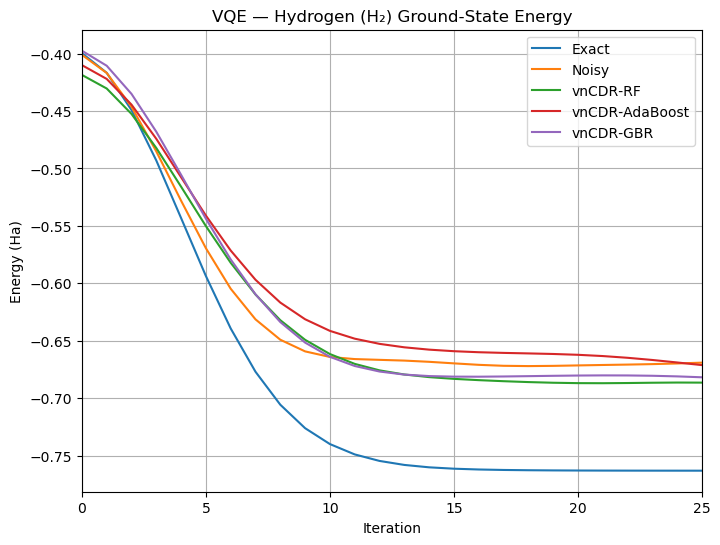

In [31]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# --- Gaussian‑smooth every trace (σ = 2) -------------------------
ysmoothed_exact  = gaussian_filter1d(history_exact,   sigma=3)
ysmoothed_noisy  = gaussian_filter1d(history_noisy,   sigma=3)
ysmoothed_rf     = gaussian_filter1d(mean_rf,         sigma=3)
ysmoothed_ada    = gaussian_filter1d(mean_adaboost,   sigma=3)
ysmoothed_stack  = gaussian_filter1d(mean_gbr,        sigma=3)

# ----------------- Plot ------------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(ysmoothed_exact,      label="Exact")
plt.plot(ysmoothed_noisy,      label="Noisy")
plt.plot(ysmoothed_rf,    label="vnCDR‑RF")
plt.plot(ysmoothed_ada,   label="vnCDR‑AdaBoost")
plt.plot(ysmoothed_stack, label="vnCDR‑GBR")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("VQE — Hydrogen (H₂) Ground‑State Energy")
plt.xlim(0, 25)
plt.grid(True)
plt.legend()
plt.show()

In [29]:
n_skip = 10  

# ------------------------------------------------------------------
# helper: compute absolute error |e_model − e_exact| 
# ------------------------------------------------------------------
def series_error(hist_model, hist_exact, skip = n_skip):
    m = min(len(hist_model), len(hist_exact))
    err = np.abs(np.asarray(hist_model[skip:m]) - np.asarray(hist_exact[skip:m]))
    return err[~np.isnan(err)]  # remove any padding artifacts

# build records using the updated error metric
records = []
for tag, hist, e_final in candidates:
    err = series_error(hist, history_exact, skip = n_skip)
    records.append({
        "method"                    : tag,
        "final_energy"             : e_final,
        "|Δe|_final"               : abs(e_final - res_exact.fun),
        "|Δe|_mean"                : err.mean(),
        "auc_|Δe|"                 : err.sum()
    })

df = (pd.DataFrame(records)
        .set_index("method")
        .sort_values("|Δe|_final"))

# percent improvement vs noisy baseline 
noise_mean = df.loc["noisy", "|Δe|_mean"]
df["mean % improvement (≥ iter 10)"] = 100 * (noise_mean - df["|Δe|_mean"]) / noise_mean

# display the results (interactive if ace_tools is available)
try:
    import ace_tools as tools
    tools.display_dataframe_to_user("cdr metrics (skip first 10 iters)", df.round(6))
except ModuleNotFoundError:
    print(df.round(6).to_string())

                        Final_Energy              |ΔE|_Final  |ΔE|_Mean  AUC_|ΔE|  Mean % Improvement (≥ iter 10)
Method                                                                                                           
Exact            -0.7630922790812452  2.6302424424029525e-05   0.000000  0.000000                      100.000000
CDR‑RF⟨5⟩                  -0.682831                0.080288   0.076955  1.616059                       17.578783
CDR‑GBR⟨5⟩                 -0.681528                 0.08159   0.080605  1.692697                       13.670175
CDR‑AdaBoost⟨5⟩             -0.67554                0.087578   0.097550  2.048548                       -4.478708
Noisy                      -0.655099                 0.10802   0.093368  1.680627                        0.000000
